# Audio Experiments

## Imports

In [18]:
%pylab inline

import numpy as np
import scipy as sp
import scipy.constants as const

from scipy.io import wavfile
from sklearn import preprocessing
from scipy import signal

from scipy.signal import butter, firwin, lfilter
from scipy.signal import freqz

Populating the interactive namespace from numpy and matplotlib


## Constants, Global Variables and Functions

In [19]:
sample_rate = 44100
duration = 0.1
tone_frequency = 8820
tone_period = 1/tone_frequency

scaler = preprocessing.MinMaxScaler()

samples = sample_rate * duration
time = np.linspace(0, duration, samples)
normedsin = lambda f,t : 2**13*sin(2*pi*f*t)

# Source: http://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter
def butter_bandpass(low_cut_frequency, high_cut_frequency, sample_rate, order=5):
    nyq = 0.5 * sample_rate
    low = low_cut_frequency / nyq
    high = high_cut_frequency / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    return b, a

def butter_bandpass_filter(data, low_cut_frequency, high_cut_frequency, sample_rate, order=5):
    b, a = butter_bandpass(low_cut_frequency, high_cut_frequency, sample_rate, order=order)
    return lfilter(b, a, data)

def fir_bandpass(low_cut_frequency, high_cut_frequency, fs, order=5):
    nyq = 0.5 * fs
    b = firwin(order+1, [low_cut_frequency, high_cut_frequency], pass_zero=False, nyq=nyq)
    return b, [1.0]

def fir_bandpass_filter(data, low_cut_frequency, high_cut_frequency, fs, order=5):
    b, a = fir_bandpass(low_cut_frequency, high_cut_frequency, fs, order=order)
    return lfilter(b, a, data)

## Tone Generation

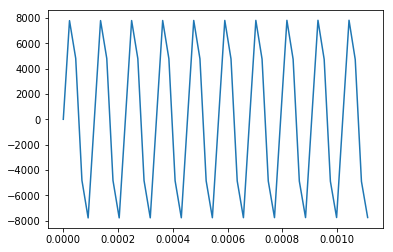

In [20]:
tone_path = "audio/tone.wav"

wave = lambda t : normedsin(tone_frequency,t)
tone_data = wave(time)

scaled_tone_data = scaler.fit_transform(np.reshape(tone_data,(tone_data.size,1)))

plot(time[0:50], tone_data[0:50])
wavfile.write(tone_path, sample_rate, tone_data.astype(np.int16))


## Load Sample Audio

In [21]:
sample_rate, sample_data = wavfile.read("audio/sample.wav")
sample_duration = sample_data.size / sample_rate
print("Sample Rate: ",sample_rate,"\nSample Duration:",sample_duration)

scaled_sample_data = np.array(scaler.fit_transform(np.reshape(sample_data,(sample_data.size,1))).squeeze())

Sample Rate:  44100 
Sample Duration: 89.31555555555556


/home/pedro/ProgramFiles/Anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int16 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [22]:
# plot(scaled_sample_data)

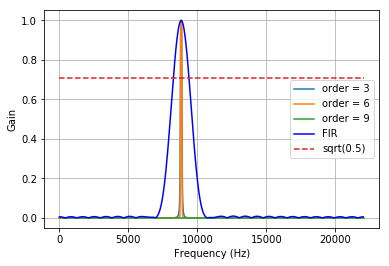

In [23]:
sample_rate
low_cut_frequency = tone_frequency - 50
high_cut_frequency = tone_frequency + 50

# Plot the frequency response for a few different filters and parameters.
plt.figure(1)
plt.clf()

for order in range(3,10,3):
    b, a = butter_bandpass(low_cut_frequency, high_cut_frequency, sample_rate, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((sample_rate * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

fir_order = 50
b, a = fir_bandpass(low_cut_frequency, high_cut_frequency, sample_rate, order=fir_order)
w, h = freqz(b)
plt.plot((sample_rate * 0.5 / np.pi) * w , abs(h), 'b', label="FIR")
    
plt.plot([0, 0.5 * sample_rate], [np.sqrt(0.5), np.sqrt(0.5)], '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

butler_order = 6
butler_filtered_sample_data = butter_bandpass_filter(scaled_sample_data,
                                                     low_cut_frequency,
                                                     high_cut_frequency,
                                                     sample_rate,
                                                     order=butler_order)

#fir_filtered_sample_data = fir_bandpass_filter(scaled_sample_data,
#                                               low_cut_frequency,
#                                               high_cut_frequency,
#                                               sample_rate,
#                                               order=fir_order)

filtered_sample_data = butler_filtered_sample_data

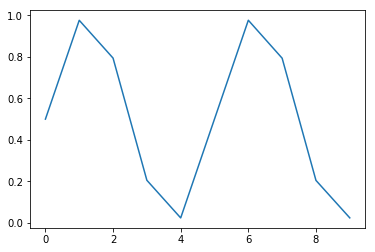

In [24]:
tone_match_data = scaled_tone_data[0:round(tone_period*sample_rate*2)].squeeze()
plot(tone_match_data)

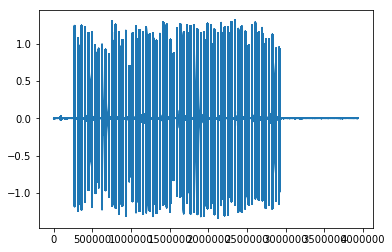

In [25]:
correlation = sp.correlate(filtered_sample_data, tone_match_data, 'valid')
plot(correlation)

In [26]:
treshold = 0.4
detected = False
last_index = 0
tone_indices = []

for index, value in enumerate(correlation):
    if value > treshold:
        if not detected:
            print ('Tone Detected at: ', index/sample_rate)
            tone_indices.append(index)            
        last_index = index
        detected = True
    elif index > last_index + sample_rate/2:
        detected = False

Tone Detected at:  6.122426303854875
Tone Detected at:  7.1257142857142854
Tone Detected at:  8.121859410430838
Tone Detected at:  9.122426303854875
Tone Detected at:  10.124240362811792
Tone Detected at:  11.128798185941044
Tone Detected at:  12.122766439909297
Tone Detected at:  13.125374149659864
Tone Detected at:  14.135578231292516
Tone Detected at:  15.134195011337868
Tone Detected at:  16.13750566893424
Tone Detected at:  17.121179138321995
Tone Detected at:  18.12390022675737
Tone Detected at:  19.121972789115645
Tone Detected at:  20.12421768707483
Tone Detected at:  21.12174603174603
Tone Detected at:  22.12467120181406
Tone Detected at:  23.122222222222224
Tone Detected at:  24.121768707482993
Tone Detected at:  25.122086167800454
Tone Detected at:  26.121972789115645
Tone Detected at:  27.122086167800454
Tone Detected at:  28.122086167800454
Tone Detected at:  29.122086167800454
Tone Detected at:  30.122086167800454
Tone Detected at:  31.121632653061223
Tone Detected at:  3

In [27]:
len(tone_indices)

61